In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import matplotlib.transforms as transforms
import matplotlib.lines as lines

class Medium:
    
    def __init__(self, refractive_index):
        self.refractive_index = refractive_index

class SphericalSurface:
     
    #outer/
    #    / inner
    #   |
    #   |A       O(xc, yc, zc)      ------ z axis -------
    #   |
    #    \
    #     \B
    #z_min z_max
    
    def __init__(self, zc, inner_medium=None, outer_medium=None, reflective=False,
                 radius = None, radius_r = None, radius_z = None,
                 z_min=-np.inf, z_max=+np.inf, xc = 0, yc = 0, color="green"):
        self.inner_medium = inner_medium
        self.outer_medium = outer_medium
        self.reflective = reflective
        
        if radius_r is None:
            radius_r = radius

        if radius_z is None:
            radius_z = radius
            
        self.radius_r = radius_r
        self.radius_z = radius_z
        
        self.xc = xc
        self.yc = yc
        self.zc = zc
        self.z_min = z_min
        self.z_max = z_max
        self.color = color
            
    
    def transform(self, ray):
        Print = False        
        
        dx = ray.dx
        dy = ray.dy
        dz = ray.dz
        x0 = ray.x
        y0 = ray.y
        z0 = ray.z
        xc = self.xc
        yc = self.yc
        zc = self.zc
     
        if Print: print("xyz:", x0, y0, z0)
        
        # |(x0,y0) + l *(dx,dy) - (xc,yc)|^2/Rr^2 + (z0 + l*dz - zc)^2/Rz^2 = 1                
        #  ((dx^2 + dy^2)/Rr^2 + dz^2/Rz^2) l^2 +
        #  ((x0-xc)dx + (y0-yc)dy)/Rr^2 l + (z0-zc)dz/Rz^2 l +  
        #  ((x0-xc)^2 + (y0-yc)^2)/Rr^2 + (z0-zc)^2/Rz^2 - 1 = 0

        Rrm2=1/np.square(self.radius_r)
        Rzm2=1/np.square(self.radius_z)
        if Print: print("Rrm2:", Rrm2)
        if Print: print("Rzm2:", Rzm2)
        
        a = (dx*dx + dy*dy)*Rrm2 + dz*dz*Rzm2
        if Print: print("a:", a)
        b = ((x0-xc)*dx + (y0-yc)*dy)*Rrm2 + (z0-zc)*dz*Rzm2
        c = (np.square(x0-xc) + np.square(y0-yc))*Rrm2 + np.square(z0-zc)*Rzm2 - 1
        
        delta = np.square(b)-a*c
        if Print: print("delta:", delta)
        abs_delta = np.abs(delta)
        
        l1 = (-b - np.sqrt(abs_delta))/a
        if Print: print("l1:", l1)
        z1 = z0 + dz * l1
        ok1 = np.logical_and(l1>=0, np.logical_and(z1 >= self.z_min, z1 <= self.z_max))
        if Print: print("ok1:", ok1)
        
        l2 = (-b + np.sqrt(abs_delta))/a
        if Print: print("l2:", l2)
        z2 = z0 + dz * l2
        ok2 = np.logical_and(l2>=0, np.logical_and(z2 >= self.z_min, z2 <= self.z_max))
        if Print: print("z2:", z2)
        if Print: print("ok2:", ok2)
        
        l = np.select([delta < 0, ok1, ok2], [0, l1, l2], 0)
        if Print: print("l:", l)
                
        xx = x0 + l*dx
        yx = y0 + l*dy
        zx = z0 + l*dz
        
        if Print: print("intersection point x,y,z", xx, yx, zx)
        if Print: print("on shell", (xx-xc)*(xx-xc)*Rrm2 + (yx-yc)*(yx-yc)*Rrm2 + (zx-zc)*(zx-zc)*Rzm2-1)

        if Print: print("     ray direction x,y,z", dx, dy, dz)
            
        nabla_x = (xx-xc)*Rrm2
        nabla_y = (yx-yc)*Rrm2
        nabla_z = (zx-zc)*Rzm2
        nabla = np.sqrt(np.square(nabla_x) + np.square(nabla_y) + np.square(nabla_z))
        nabla_x = nabla_x/nabla
        nabla_y = nabla_y/nabla
        nabla_z = nabla_z/nabla
        if Print: print("             nabla x,y,z", nabla_x, nabla_y, nabla_z)
            
        
        nabla_d = nabla_x*dx + nabla_y*dy + nabla_z*dz        
        vx = dx - nabla_d * nabla_x
        vy = dy - nabla_d * nabla_y
        vz = dz - nabla_d * nabla_z
        v = np.sqrt(np.square(vx) + np.square(vy) + np.square(vz) + np.square(1E-10))
        vx = vx / v
        vy = vy / v
        vz = vz / v
        if Print: print("            vector x,y,z", vx, vy, vz)
        
        
        # (vx, vy, vz) .（n1 (dx, dy, dz)  - n2 alpha * (vx, vy, vz)) = 0
        # alpha = n1/n2 (vx, vy, vz) . (dx, dy, dz)
        # new (dx, dy, dz) = alpha (vx, vy, vz) + sqrt(1 - alpha^2) (nabla x, nabla y, nabla y)
        
        if self.reflective:
            ratio = 1
        else:
            n1 = np.where(nabla_d > 0, self.inner_medium.refractive_index, self.outer_medium.refractive_index)
            n2 = np.where(nabla_d > 0, self.outer_medium.refractive_index, self.inner_medium.refractive_index);
            if Print: print("n1:", n1)
            if Print: print("n2:", n2)
            ratio = n1 / n2
            
        alpha = ratio * (vx*dx + vy*dy + vz*dz)
        if Print: print("alpha:", alpha)
            
        beta = np.sqrt(np.abs(1-np.square(alpha)))
        if Print: print(" beta:", beta)
            
        if self.reflective:
            beta = -beta
        
        new_dx = alpha*vx + beta*nabla_x*np.sign(nabla_d)
        new_dy = alpha*vy + beta*nabla_y*np.sign(nabla_d)
        new_dz = alpha*vz + beta*nabla_z*np.sign(nabla_d)
        
        if Print: print(" new ray direction x,y,z", new_dx, new_dy, new_dz)
        
        new_ray = ray.clone()
        new_ray.x = xx
        new_ray.y = yx
        new_ray.z = zx

        new_ray.dx = new_dx
        new_ray.dy = new_dy
        new_ray.dz = new_dz
                
        return new_ray
    

    def draw_figure(self, ax):
        
        #clip_box=transforms.Bbox([[self.z_min, -np.inf], [self.z_max, +np.inf]])
        #clip_box=transforms.Bbox([[100, 0], [200, 1000]])
        
        z_min = self.z_min
        z_max = self.z_max
        if np.isinf(z_min): z_min = -100
        if np.isinf(z_max): z_max = +100
            
        
        rect = patches.Rectangle((z_min, -100), z_max - z_min, 200, facecolor="none", edgecolor="none")
        #rect = patches.Rectangle((5, -10), 20, 20, facecolor="none", edgecolor="none")
        
        circle = patches.Ellipse((self.zc, self.yc), 2*self.radius_z, 2*self.radius_r,\
                        color=self.color, fill=False, clip_on=True)
        
        ax.add_artist(rect)
        ax.add_artist(circle)
        
        #circle.set_clip_box(clip_box)
        
        #print(rect)
        #print(circle)
        circle.set_clip_path(rect)
    

class CircularDiaphragm:
    def __init__(self, radius, zc, xc = 0, yc = 0, transparency="inner", color="black"): # transparency = 'outer'
        self.xc = xc
        self.yc = yc
        self.zc = zc
        self.radius = radius
        self.transparency = transparency
        self.color = color
    
    def transform(self, ray):
        n = ray.x.shape[0]
        
        x = ray.x + ray.dx/ray.dz * (self.zc - ray.z)
        y = ray.y + ray.dy/ray.dz * (self.zc - ray.z)
        z = np.ones(n) * self.zc
        
        r = np.sqrt(np.square(x) + np.square(y))
                        
        screen_ray = Ray(n, color = ray.color)
        radius = self.radius
        
        if self.transparency == "inner":
            inner = np.logical_and(r < radius, ray.dz*(self.zc - ray.z) > 0)
            screen_ray.x = x[inner]
            screen_ray.y = y[inner]
            screen_ray.z = z[inner]
            screen_ray.dx = ray.dx[inner]
            screen_ray.dy = ray.dy[inner]
            screen_ray.dz = ray.dz[inner]
        elif self.transparency == "outer":
            outer = np.logical_and(r >= radius, ray.dz*(self.zc - ray.z) > 0)
            screen_ray.x = x[outer]
            screen_ray.y = y[outer]
            screen_ray.z = z[outer]
            screen_ray.dx = ray.dx[outer]
            screen_ray.dy = ray.dy[outer]
            screen_ray.dz = ray.dz[outer]
            
        return screen_ray
        

    def draw_figure(self, ax):
        
        if self.transparency == "inner":
            #ax.plot([self.zc, self.zc],[self.yc - 100, self.yc - self.radius], color = self.color)        
            #ax.plot([self.zc, self.zc],[self.yc + self.radius, self.yc + 100], color = self.color)        
            line = lines.Line2D([self.zc, self.zc],[self.yc - 100, self.yc - self.radius], color = self.color)
            ax.add_line(line)
            line = lines.Line2D([self.zc, self.zc],[self.yc + self.radius, self.yc + 100], color = self.color)
            ax.add_line(line)
        elif self.transparency == "outer":
            ax.plot([self.zc, self.zc],[self.yc - self.radius, self.yc + self.radius], color = self.color)        
        
    
    
class Ray:
    
    def __init__(self, n, color):
        self.color = color
        
    def clone(self):
        ray = Ray(self.x.shape[0], self.color)
        ray.x = np.copy(self.x)
        ray.y = np.copy(self.y)
        ray.z = np.copy(self.z)
        ray.dx = np.copy(self.dx)
        ray.dy = np.copy(self.dy)
        ray.dz = np.copy(self.dz)
        return ray
    

class PointSource:
    
    def __init__(self,x,y,z,theta=2*np.pi,color="red"):
        self.x=x
        self.y=y
        self.z=z
        self.theta=theta
        self.color=color

    def generate_ray(self, n):
        
        ray = Ray(n, self.color)        
        ray.x = np.full(n, self.x)
        ray.y = np.full(n, self.y)
        ray.z = np.full(n, self.z)
        
        
        thetas = np.random.rand(n) * self.theta
        phis = np.random.rand(n) * 2 * np.pi
        ray.dx = np.sin(thetas) * np.cos(phis)
        ray.dy = np.sin(thetas) * np.sin(phis)
        ray.dz = np.cos(thetas)
        
        return ray
    
    def draw_figure(self, ax):
        ax.scatter([self.z], [self.y],c=self.color,marker='*',s=100)

        
class SquareSource:
    
    def __init__(self,x,y,z, w, h, theta=2*np.pi,color="red", fill=False):
        self.x=x
        self.y=y
        self.z=z
        self.w = w
        self.h = h
        self.fill = fill
        self.theta=theta
        self.color=color

    def generate_ray(self, n):
        
        ray = Ray(n, self.color)        
        if self.fill:
            ray.x = self.x + (np.random.rand(n)-0.5)*self.w
            ray.y = self.y + (np.random.rand(n)-0.5)*self.h
        else:
            
            x1 = self.x + (np.random.rand(n)-0.5)*self.w
            x2 = self.x + (np.random.randint(2, size=n)-0.5)*self.w
            
            y1 = self.y + (np.random.rand(n)-0.5)*self.h
            y2 = self.y + (np.random.randint(2, size=n)-0.5)*self.h
            
            sel = np.random.randint(2, size=n)
            
            ray.x = np.where(sel, x1, x2)
            ray.y = np.where(sel, y2, y1)
            
        ray.z = np.full(n, self.z)
        
        
        thetas = np.random.rand(n) * self.theta
        phis = np.random.rand(n) * 2 * np.pi
        ray.dx = np.sin(thetas) * np.cos(phis)
        ray.dy = np.sin(thetas) * np.sin(phis)
        ray.dz = np.cos(thetas)
        
        return ray
    
    def draw_figure(self, ax):
        dw = self.w
        dh = self.h
        if np.isinf(dw): dw = 1000
        if np.isinf(dh): dh = 1000
        x = self.x
        y = self.y
        z = self.z
        ax.plot([z,z], [y-dh/2, y+dh/2], c = self.color)
        
        
class Screen:

    def __init__(self, z, w=np.Infinity, h=np.Infinity, x=0, y=0, color="gray"):
        self.x=x
        self.y=y
        self.z=z
        self.w=w
        self.h=h
        self.color = color
        self.ray = None
        
    def transform(self, ray):
        n = ray.x.shape[0]
        
        x = ray.x + ray.dx/ray.dz * (self.z - ray.z)
        y = ray.y + ray.dy/ray.dz * (self.z - ray.z)
        z = np.copy(self.z)
        
        screen_ray = ray.clone()
        screen_ray.x = x
        screen_ray.y = y
        screen_ray.z = z
        screen_ray.dx = np.copy(ray.dx)
        screen_ray.dy = np.copy(ray.dy)
        screen_ray.dz = np.copy(ray.dz)
        
        self.ray = screen_ray.clone()
        
        return screen_ray
    
    def draw_figure(self, ax):
        dw = self.w
        dh = self.h
        if np.isinf(dw): dw = 1000
        if np.isinf(dh): dh = 1000
        x = self.x
        y = self.y
        z = self.z
        #ax.plot([z,z], [y-dw/2,y+dw/2], c='white')
        ax.plot([z,z], [y-dh/2,y+dh/2], c=self.color)
        
        
    def draw_image(self, xlim=None, ylim=None, ax=None, title="", aspect="equal"):
        
        if ax is None:
            fig = plt.figure(figsize=(3,3))
            ax = fig.add_axes([0,0,1,1])

        if xlim is None:
            if not np.isinf(self.w):
                ax.set_xlim(self.x-self.w/2, self.x+self.w/2)
        else:
            ax.set_xlim(xlim)
            

        if ylim is None:
            if not np.isinf(self.h):
                ax.set_ylim(self.y-self.h/2, self.y+self.h/2)
        else:
            ax.set_ylim(ylim)

        ray = self.ray
        if ray is not None:
            ax.scatter(ray.x, ray.y, c= ray.color, s=1)
        #ax.set_facecolor(self.color)
        if aspect is not None and not (aspect == ""):
            ax.set_aspect(aspect)
        ax.set_facecolor("white")
        ax.set_title(title)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        plt.show()
    
class System:
    
    
    def __init__(self, color="white"):
        self.devices = []
        self.rays = []
        self.color=color
        pass
    
    def set_source(self, source):
        self.source = source

    def add_device(self, device):
        self.devices.append(device)
    
    def simulate(self, n):
        if self.source is None:
            print("source is None")
            return
        
        ray = self.source.generate_ray(n)
        self.rays.append(ray.clone())
    
        for device in self.devices:    
            ray = device.transform(ray)
            self.rays.append(ray.clone())
        
        
    def draw_figure(self, title="", xlim=(-2, 25), ylim=(-10, 10)):
            
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_axes([0,0,1,1])
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

        ax.set_title(title)
        ax.set_aspect("equal")
        ax.set_xlabel("z")
        ax.set_ylabel("y")
        ax.set_facecolor(self.color)

        if self.source is not None:
            self.source.draw_figure(ax)

        for self.device in self.devices:    
            self.device.draw_figure(ax)
                        

        plt.show()
        
        


# 简单实验

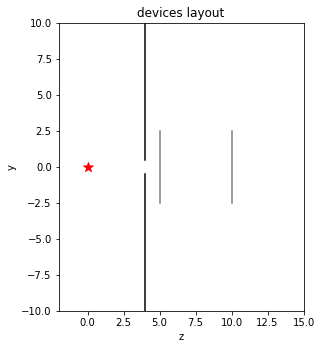

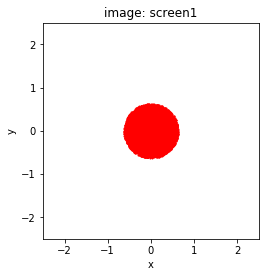

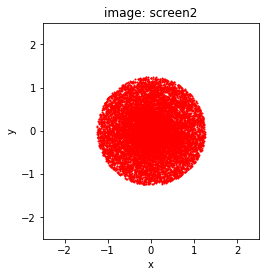

In [2]:
theta=np.arctan(0.5/4)+0.1
source=PointSource(x=0, y=0, z=0, theta=1,color="red")
screen1=Screen(x=0, y=0, z=5, w=5, h=5,color="gray")
screen2=Screen(x=0, y=0, z=10, w=5, h=5,color="gray")
diaphragm=CircularDiaphragm(zc=4, radius=0.5)

sys=System(color="white")
sys.set_source(source)
sys.add_device(diaphragm)
sys.add_device(screen1)
sys.add_device(screen2)
sys.simulate(100000)

sys.draw_figure(xlim=(-2, 15), ylim= (-10, 10), title="devices layout")
screen1.draw_image(title="image: screen1")
screen2.draw_image(title="image: screen2")

# 失焦

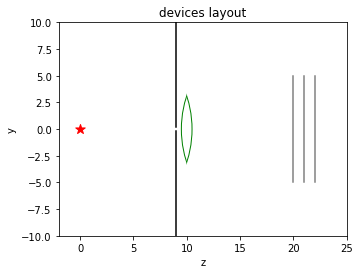

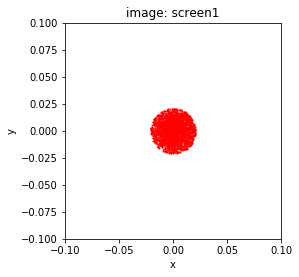

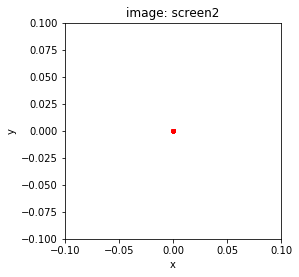

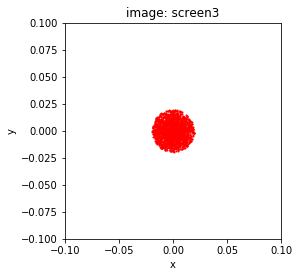

In [3]:
def thin_lens_system(diaphragm_radius=1):
    
    theta=np.arctan(diaphragm_radius/9)+0.2
    source=PointSource(x=0, y=0, z=0, theta=1,color="red")
    diaphragm = CircularDiaphragm(zc=9, radius=diaphragm_radius, color="black")

    air=Medium(refractive_index=1)
    glass=Medium(refractive_index=2)

    len_center=10
    len_thickness=1
    radius=10
    #print("f=", (2-1)*radius/2)
    
    surface1=SphericalSurface(inner_medium=glass, outer_medium=air, radius=radius,\
                          zc=len_center+radius-len_thickness/2, z_max=len_center)            
    surface2=SphericalSurface(inner_medium=glass, outer_medium=air, radius=radius,\
                              zc=len_center-radius+len_thickness/2, z_min=len_center)

    sys=System(color="white")
    sys.set_source(source)
    sys.add_device(diaphragm)
    sys.add_device(surface1)
    sys.add_device(surface2)
    
    return sys
    
    
sys = thin_lens_system(diaphragm_radius=0.2)
screen1=Screen(x=0, y=0, z=21-1, w=10, h=10, color="gray")
screen2=Screen(x=0, y=0, z=21+0, w=10, h=10, color="gray")
screen3=Screen(x=0, y=0, z=21+1, w=10, h=10, color="gray")
sys.add_device(screen1)
sys.add_device(screen2)
sys.add_device(screen3)
sys.draw_figure(xlim=(-2, 25), ylim= (-10, 10), title="devices layout")

sys.simulate(100000)
w=0.1
screen1.draw_image(xlim=(-w,w), ylim=(-w,w), title="image: screen1")
screen2.draw_image(xlim=(-w,w), ylim=(-w,w), title="image: screen2")
screen3.draw_image(xlim=(-w,w), ylim=(-w,w), title="image: screen3")


# 球差

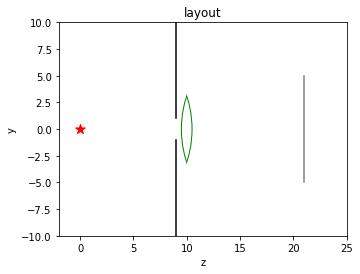

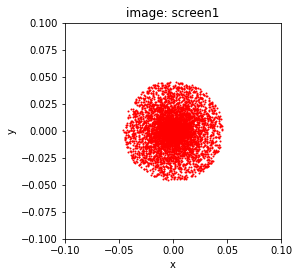

In [4]:
sys = thin_lens_system(diaphragm_radius=1)
screen1=Screen(x=0, y=0, z=21, w=10, h=10, color="gray")
sys.add_device(screen1)
sys.draw_figure(xlim=(-2, 25), ylim= (-10, 10), title="layout")

sys.simulate(100000)
w=0.1
screen1.draw_image(xlim=(-w,w), ylim=(-w,w), title="image: screen1")

# 彗差

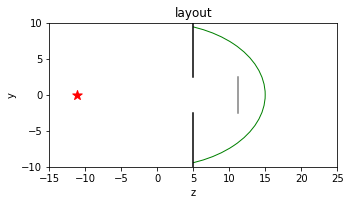

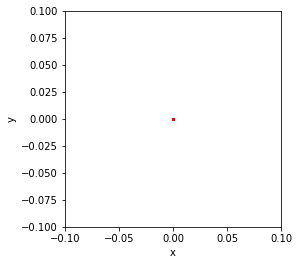

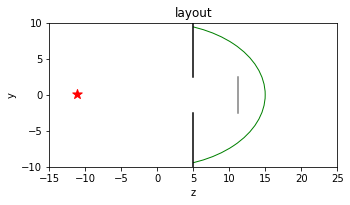

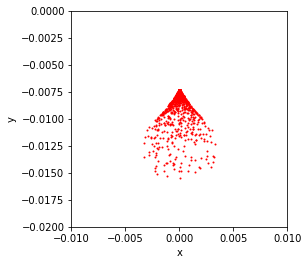

In [5]:
def sphere_system():
    
    radius=10    
    diaphragm_radius=8
    theta=np.pi/2
    
    source=PointSource(x=0, y=0, z=0, theta=theta,color="red")
    diaphragm = CircularDiaphragm(zc=radius*0.5, radius=diaphragm_radius, color="black")

    surface1=SphericalSurface(radius=radius, reflective=True,\
                          zc=0, z_min=radius*0.5)            

    screen=Screen(x=0, y=0, z=0, w=15, h=15, color="gray")
    
    sys=System(color="white")
    sys.set_source(source)
    sys.add_device(diaphragm)
    sys.add_device(surface1)
    sys.add_device(screen)
    
    
    return sys

sys = sphere_system()

sys.devices[0].radius = 2.5

zc = sys.devices[1].zc
sys.devices[1].radius_r = 10
sys.devices[1].radius_z = 15
c = np.sqrt(15*15 - 10*10)
f1 = zc + c
f2 = zc - c

sys.source.z = f2
sys.devices[-1].z = f1
sys.devices[-1].w = 5
sys.devices[-1].h = 5


sys.draw_figure(xlim=(-15, 25), ylim= (-10, 10), title="layout")
sys.simulate(100000)
w=0.1
sys.devices[-1].draw_image(xlim=(-w,w), ylim=(-w,w))

y0=0.05
sys.source.y = y0
sys.draw_figure(xlim=(-15, 25), ylim= (-10, 10), title="layout")
sys.simulate(10000)
w=0.01
sys.devices[-1].draw_image(xlim=(-w, w), ylim=(-w-0.01,w-0.01), aspect="")


# 像散和像场弯曲

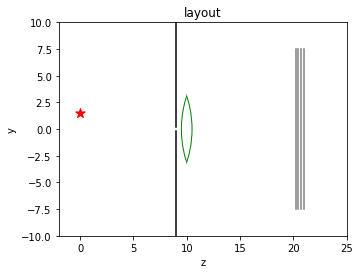

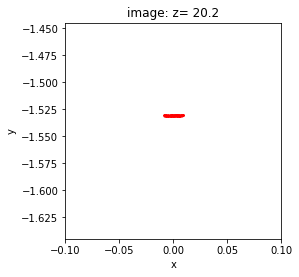

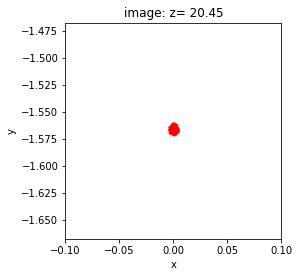

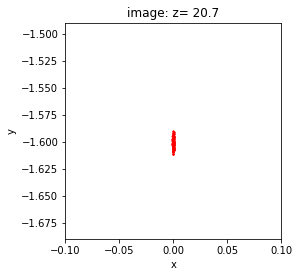

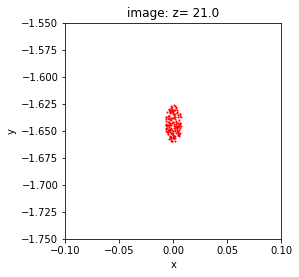

In [6]:
sys = thin_lens_system(diaphragm_radius=0.2)
y0 = 1.5
sys.source.y = y0
screen1=Screen(x=0, y=0, z=21, w=15, h=15, color="gray")
screen2=Screen(x=0, y=0, z=20.2, w=15, h=15, color="gray")
screen3=Screen(x=0, y=0, z=20.7, w=15, h=15, color="gray")
screen4=Screen(x=0, y=0, z=20.45, w=15, h=15, color="gray")

sys.add_device(screen1)
sys.add_device(screen2)
sys.add_device(screen3)
sys.add_device(screen4)
sys.draw_figure(xlim=(-2, 25), ylim= (-10, 10), title="layout")

sys.simulate(100000)
w=0.1
screen2.draw_image(xlim=(-w,w), ylim=(-w-y0*1.03, w-y0*1.03), title="image: z= "+ str(20.2))
screen4.draw_image(xlim=(-w,w), ylim=(-w-y0*1.045, w-y0*1.045), title="image: z= "+ str(20.45))
screen3.draw_image(xlim=(-w,w), ylim=(-w-y0*1.06, w-y0*1.06), title="image: z= "+ str(20.7))
screen1.draw_image(xlim=(-w,w), ylim=(-w-y0*1.1, w-y0*1.1), title="image: z= " + str(21.0))


# 畸变

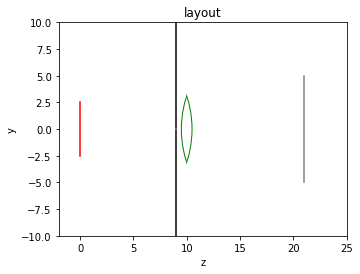

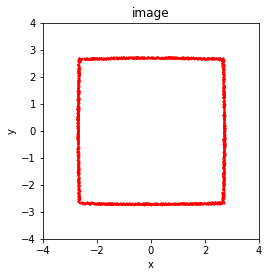

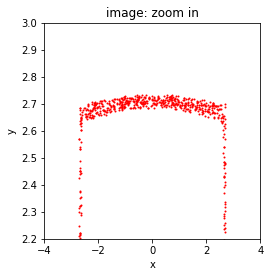

In [7]:
sys = thin_lens_system(diaphragm_radius=0.1)
sys.source = SquareSource(x=0, y=0, z=0, w=5, h=5, theta=np.arctan(4/9))
screen1=Screen(x=0, y=0, z=21, w=10, h=10, color="gray")
sys.add_device(screen1)
sys.draw_figure(xlim=(-2, 25), ylim= (-10, 10), title="layout")

sys.simulate(5000000)
w=4
screen1.draw_image(xlim=(-w,w), ylim=(-w,w), title="image")
screen1.draw_image(xlim=(-w,w), ylim=(2.2,3.0), title="image: zoom in", aspect="")


# 球面反射镜球心齐明点

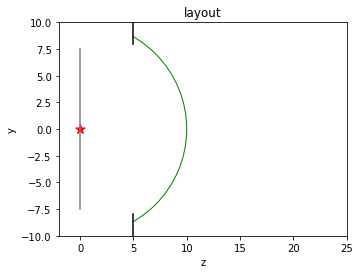

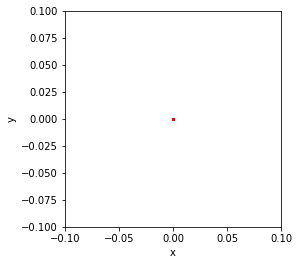

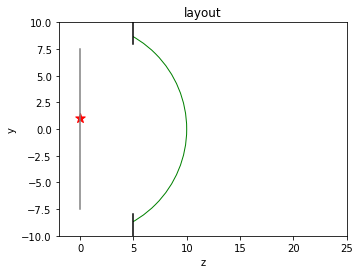

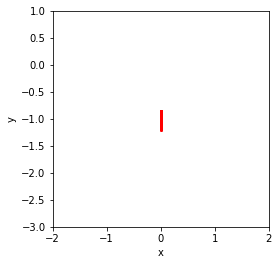

In [8]:

sys = sphere_system()

sys.draw_figure(xlim=(-2, 25), ylim= (-10, 10), title="layout")
sys.simulate(10000)
w=0.1
sys.devices[-1].draw_image(xlim=(-w,w), ylim=(-w,w))

y0=1
sys.source.y = y0
sys.draw_figure(xlim=(-2, 25), ylim= (-10, 10), title="layout")
sys.simulate(10000)
w=2
sys.devices[-1].draw_image(xlim=(-w, w), ylim=(-w-y0,w-y0), aspect="")
